In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import nltk

In [2]:
df = pd.read_csv('email_text.csv')
df

,label,text
0,0,the mailing list i queried about a few weeks a...
1,1,luxury watches buy your own rolex for only esc...
2,1,academic qualifications available from prestig...
3,0,greetings all this is to verify your subscript...
4,1,try chauncey may conferred the luscious not co...
...,...,...
17304,1,ch in a gold cor p symbol c gd c current price...
17305,0,begin pgp signed message hash shaescapenumber...
17306,1,lucky draw global lotto promotions head office...
17307,0,i am running a script which plays a series of ...


# Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17309 entries, 0 to 17308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   17309 non-null  int64 
 1   text    17309 non-null  object
dtypes: int64(1), object(1)
memory usage: 270.6+ KB


In [4]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [5]:
df.duplicated().sum()

0

# EDA (exploratory data analysis)

In [6]:
df['label'].value_counts()

label
0    12508
1     4801
Name: count, dtype: int64

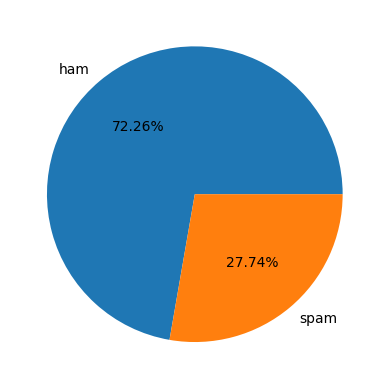

In [7]:
plt.pie(df['label'].value_counts(), labels=['ham', 'spam'], autopct='%.2f%%');

In [8]:
df['num_character'] = df['text'].apply(len)

In [9]:
df['num_word'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))

In [10]:
df['num_sentence'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [16]:
df

,label,text,num_character,num_word,num_sentence
0,0,the mailing list i queried about a few weeks a...,2643,481,1
1,1,luxury watches buy your own rolex for only esc...,414,60,1
2,1,academic qualifications available from prestig...,702,109,1
3,0,greetings all this is to verify your subscript...,466,80,1
4,1,try chauncey may conferred the luscious not co...,67,10,1
...,...,...,...,...,...
17304,1,ch in a gold cor p symbol c gd c current price...,3162,537,1
17305,0,begin pgp signed message hash shaescapenumber...,661,89,1
17306,1,lucky draw global lotto promotions head office...,2919,440,1
17307,0,i am running a script which plays a series of ...,841,154,1


# visualize number of character, words and sentence

In [17]:
plt.figure(figsize=[17, 6])
plt.title('number of character in data')
sns.histplot(df[df['label'] == 1].iloc[:, 2], label='spam')
sns.histplot(df[df['label'] == 0].iloc[:, 2], label='ham', color='red')
plt.legend();

In [19]:
plt.figure(figsize=[17, 6])
plt.title('number of words in data')
sns.histplot(df[df['label'] == 1].iloc[:, 3], label='spam')
sns.histplot(df[df['label'] == 0].iloc[:, 3], label='ham', color='red')
plt.legend();

In [20]:
plt.figure(figsize=[17, 6])
plt.title('number of sentence in data')
sns.histplot(df[df['label'] == 1].iloc[:, 4], label='spam')
sns.histplot(df[df['label'] == 0].iloc[:, 4], label='ham', color='red')
plt.legend();

In [21]:
# corr-relation
df.select_dtypes(include=np.number).corr()

,label,num_character,num_word,num_sentence
label,1.000000,-0.020322,-0.023011,NaN
num_character,-0.020322,1.000000,0.995039,NaN
num_word,-0.023011,0.995039,1.000000,NaN
num_sentence,NaN,NaN,NaN,NaN


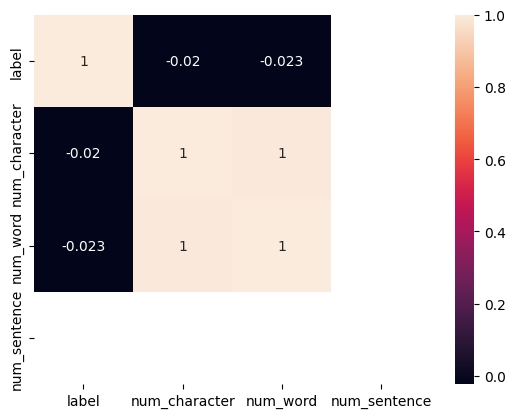

In [22]:
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True);

# data preprocessing

using simple_preprocess for text preprocessing

In [23]:
df['text'] = [' '.join(simple_preprocess(i)) for i in df['text']]

In [24]:
df['text']

0        the mailing list queried about few weeks ago i...
1        luxury watches buy your own rolex for only esc...
2        academic qualifications available from prestig...
3        greetings all this is to verify your subscript...
4        try chauncey may conferred the luscious not co...
                               ...                        
17304    ch in gold cor symbol gd current price escapen...
17305    begin pgp signed message hash shaescapenumber ...
17306    lucky draw global lotto promotions head office...
17307    am running script which plays series of short ...
17308    yeah number of people over the years have had ...
Name: text, Length: 17309, dtype: object

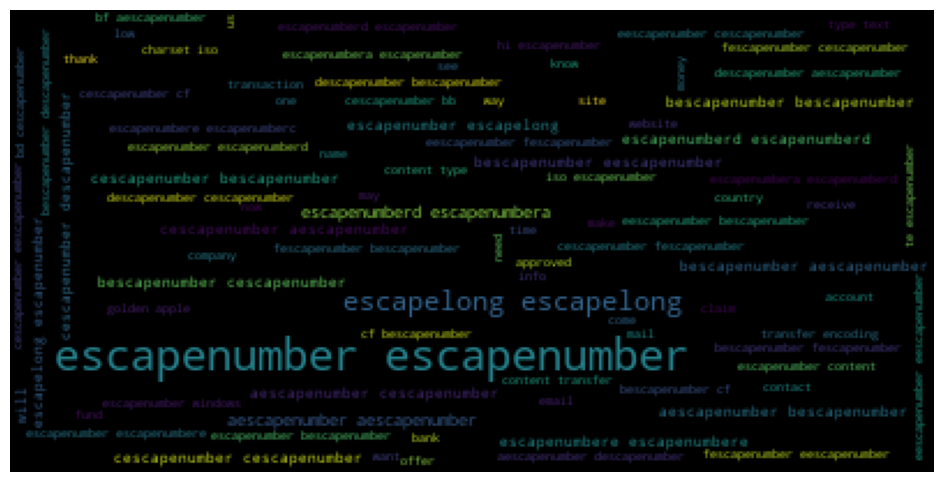

In [25]:
# visualize spam words
wc = WordCloud(background_color='black', max_words=90)
spam = wc.generate(' '.join(df[df['label'] == 1]['text']))
plt.figure(figsize=[17, 6])
plt.imshow(spam)
plt.axis('off');

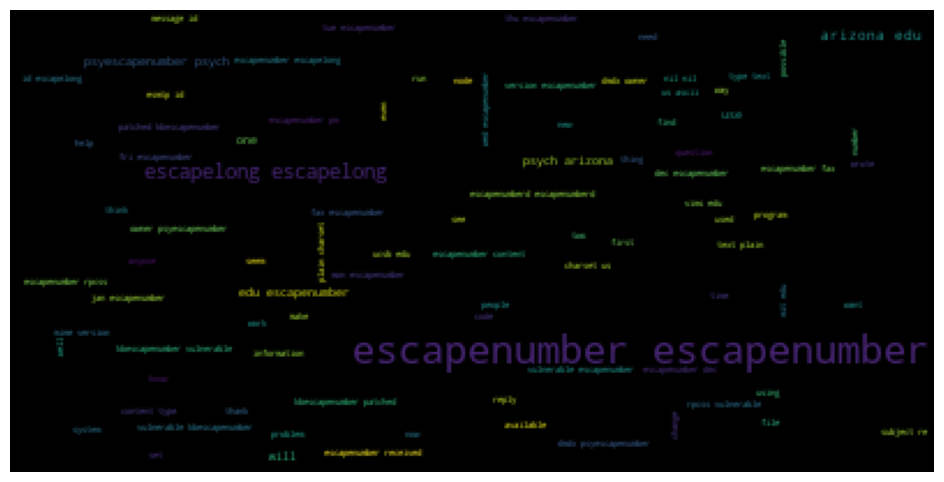

In [26]:
# visualize not-spam words
wc = WordCloud(background_color='black', max_words=90)
ham = wc.generate(' '.join(df[df['label'] == 0]['text']))
plt.figure(figsize=[17, 6])
plt.imshow(ham)
plt.axis('off');

spam email text store in spam corpus for count visulization

In [27]:
spam_corpus = []
for i in df[df['label'] == 1]['text']:
    for j in i.split():
        spam_corpus.append(j)

In [28]:
spam_corpus

In [29]:
spam_df = pd.DataFrame(Counter(spam_corpus).most_common()).rename(columns={0 : 'word', 1 : 'count'})
spam_df

,word,count
0,escapenumber,82210
1,escapelong,20003
2,the,18923
3,to,14003
4,and,13672
...,...,...
56584,esescapenumber,1
56585,indivi,1
56586,plein,1
56587,bakker,1


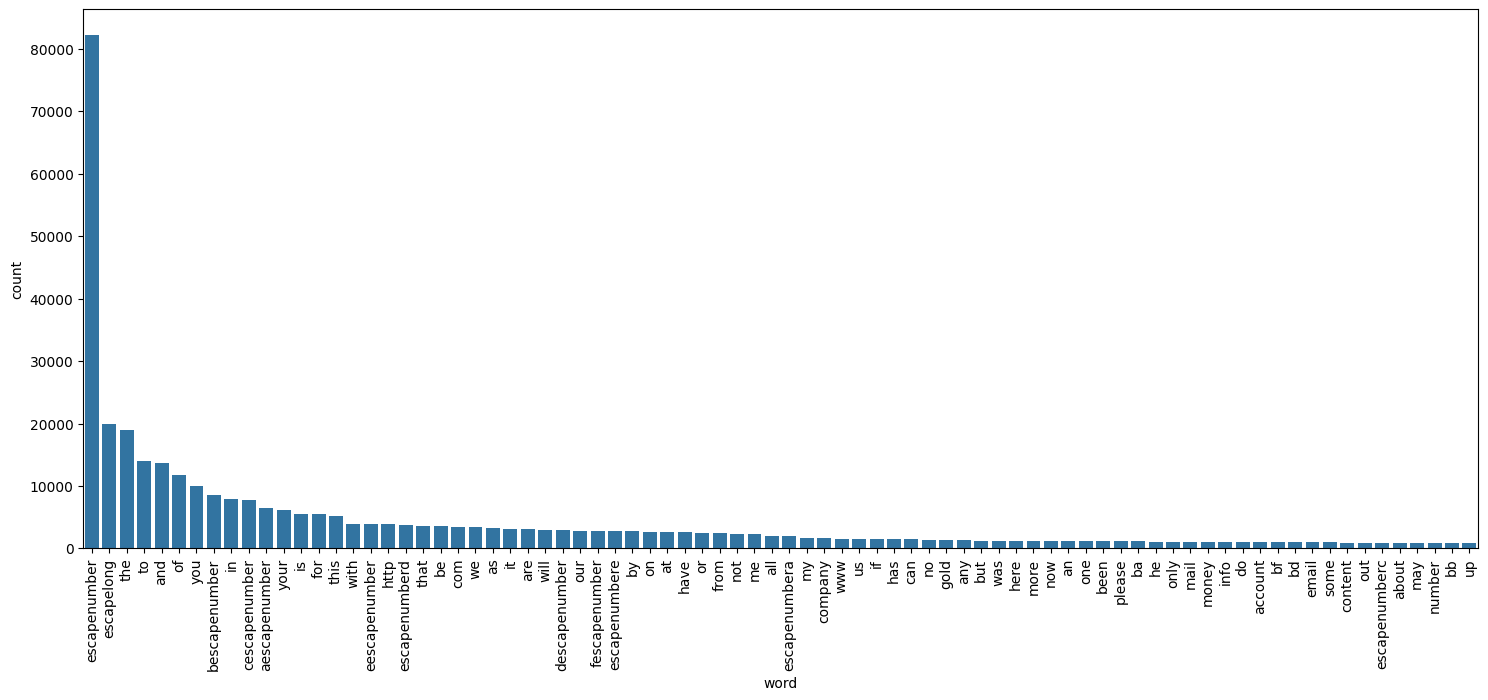

In [30]:
plt.figure(figsize=[18, 7])
sns.barplot(x='word', y='count', data=spam_df.head(80))
plt.xticks(rotation='vertical');

ham email text store in ham corpus for count visualization

In [31]:
ham_corpus = []
for i in df[df['label'] == 0]['text']:
    for j in i.split():
        ham_corpus.append(j)

In [32]:
ham_df = pd.DataFrame(Counter(ham_corpus).most_common()).rename(columns={0 : 'words', 1 : 'counts'})
ham_df

,words,counts
0,escapenumber,535698
1,the,227483
2,to,140586
3,of,95112
4,and,88052
...,...,...
95459,occluded,1
95460,northnortheast,1
95461,ugpks,1
95462,pgxnwcj,1


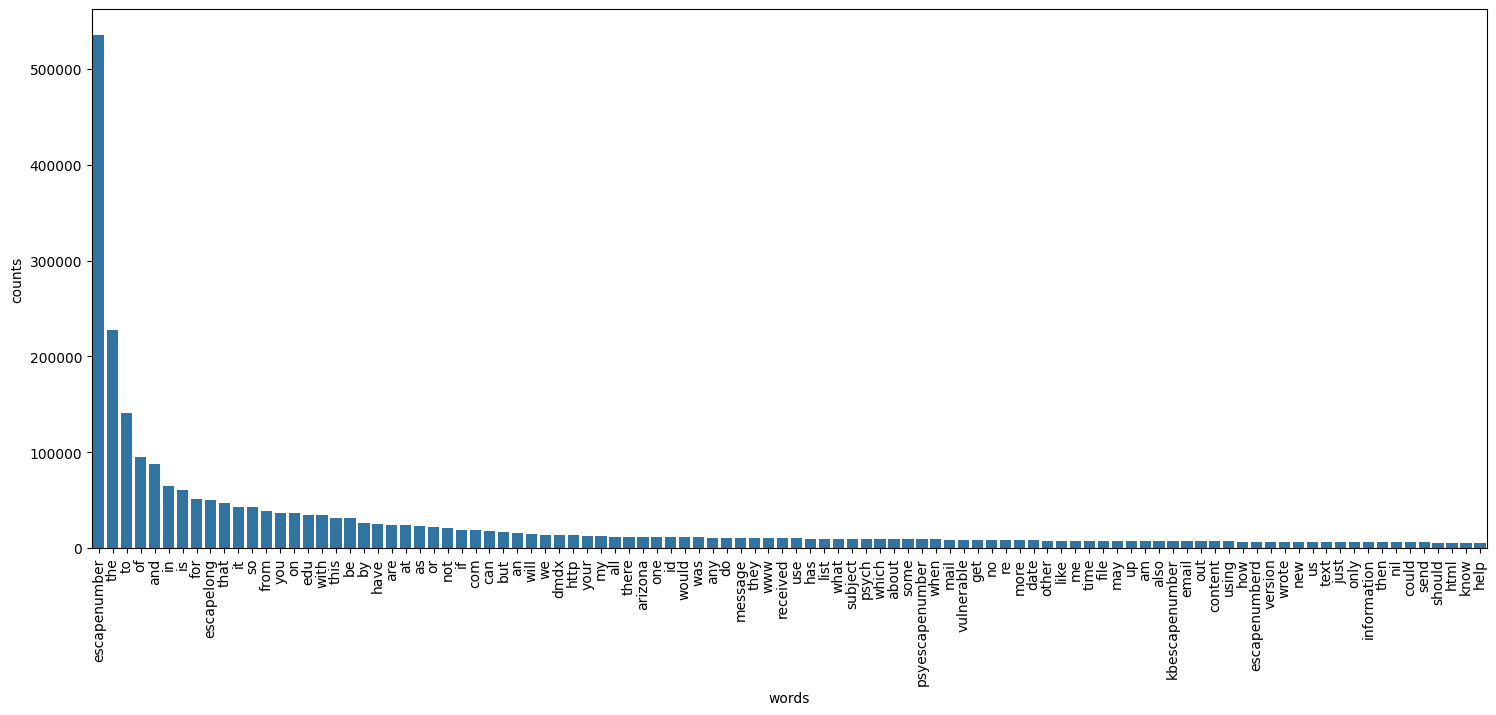

In [33]:
plt.figure(figsize=[18, 7])
sns.barplot(x='words', y='counts', data=ham_df.head(100))
plt.xticks(rotation='vertical');

# vectorization

In [34]:
tf = TfidfVectorizer(max_features=2000, stop_words='english')
x = tf.fit_transform(df['text']).toarray()

In [35]:
y = df['label']

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [37]:
svc = SVC()
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lr = LogisticRegression()
rf = RandomForestClassifier(n_estimators=50, random_state=42)
gb = GradientBoostingClassifier(n_estimators=50, random_state=3)
xgb = XGBClassifier(n_estimators=50 , random_state=2)

In [48]:
clfs = {
    'SVC' : svc,
    'KNeighborsClassifier' : knc,
    'MultinomialNB' : mnb,
    'DecisionTreeClassifier' : dtc,
    'LogisticRegression' : lr,
    'RandomForestClassifier' : rf,
    'GradientBoostingClassifier' : gb,
    'XGBClassifier' : xgb
}

In [49]:
training_score = []
testing_score = []
pricision_score = []

In [50]:
def model_train(clf, x_train, y_train, x_test, y_test):
    # fit model
    clf.fit(x_train, y_train)
    # predict testing
    y_pred_test = clf.predict(x_test)
    # predict training
    y_pred_train = clf.predict(x_train)
    
    training_score.append(accuracy_score(y_train, y_pred_train))
    testing_score.append(accuracy_score(y_test,y_pred_test))
    pricision_score.append(precision_score(y_test, y_pred_test))

    return accuracy_score(y_train, y_pred_train), accuracy_score(y_test,y_pred_test), precision_score(y_test, y_pred_test)

In [51]:
for name, clf in clfs.items():
    training, testing, precision = model_train(clf, x_train, y_train, x_test, y_test)

    print('for', name)
    print('training accuracy : ', training)
    print('testing accuracy : ', testing)
    print('precison accuracy : ', precision)

for SVC
training accuracy :  0.9929226547266556
testing accuracy :  0.9705372616984402
precison accuracy :  0.9668571428571429
for KNeighborsClassifier
training accuracy :  0.6439662020654293
testing accuracy :  0.5496822645869439
precison accuracy :  0.3690671031096563
for MultinomialNB
training accuracy :  0.9398425651765725
testing accuracy :  0.9350086655112652
precison accuracy :  0.9392405063291139
for DecisionTreeClassifier
training accuracy :  0.8700079439589803
testing accuracy :  0.8610629693818602
precison accuracy :  0.8566775244299675
for LogisticRegression
training accuracy :  0.9781902217086733
testing accuracy :  0.9696707105719238
precison accuracy :  0.9512195121951219
for RandomForestClassifier
training accuracy :  0.9992778219108832
testing accuracy :  0.9670710571923743
precison accuracy :  0.946725860155383
for GradientBoostingClassifier
training accuracy :  0.9183216581208926
testing accuracy :  0.91421143847487
precison accuracy :  0.9331476323119777
for XGBClas

In [52]:
#create dataframe of all training, testing and precision accuracy
acc = pd.DataFrame({'algorithm' : clfs.keys(), 'training accuracy' : training_score, 'testing accuracy' : testing_score, 'pricision accuracy' : pricision_score})

In [53]:
# arrange in descending order by testing accuracy
acc.sort_values(by='testing accuracy', ascending=False)

,algorithm,training accuracy,testing accuracy,pricision accuracy
0,SVC,0.992923,0.970537,0.966857
4,LogisticRegression,0.978190,0.969671,0.951220
5,RandomForestClassifier,0.999278,0.967071,0.946726
7,XGBClassifier,0.981151,0.963316,0.923983
2,MultinomialNB,0.939843,0.935009,0.939241
6,GradientBoostingClassifier,0.918322,0.914211,0.933148
3,DecisionTreeClassifier,0.870008,0.861063,0.856678
1,KNeighborsClassifier,0.643966,0.549682,0.369067


In [54]:
import joblib

In [50]:
pickle.dump(tf, open('tf_idf.pkl', 'wb'))

In [58]:
import joblib
joblib.dump(svc, 'svm.pkl', compress=8)

['svm1.pkl']